In [50]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import time
from mpl_toolkits import mplot3d
plt.rcParams.update({'font.size': 14})

from utilities import error, convert1D_to_2D, plot_phi,residual
def prepare_phi_and_S(Nx,Ny,dx_list,dy_list,phi,L, H, convert_to_K = False):

    # Generate RHS source terms matrix and unknowns 'phi' with Dirichlet BCs
    if convert_to_K:
        S = np.zeros((Nx*Ny))
    else:   
        S = np.zeros((Nx,Ny))

    # RHS source terms
    for i in range(1,Nx-1):
        for j in range(1,Ny-1):
            x = i * dx_list[i]
            y = j * dy_list[j]
            
            source = 50000*np.exp(-50*((1-x)**2 + y**2)) * (100*((1-x)**2+y**2) - 2)
            
            if convert_to_K:
                k = (j - 1) * Nx + i
                S[k] = source
            else:
                S[i,j] = source

    
    ## Right BC
    i = Nx-1 
    for j in range(1,Ny-1):

        x = i * dx_list[i]
        y = j * dy_list[j]
        phiR = 100 * (1-y) + 500*np.exp(-50*y**2)
        
        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiR
            S[k] = phiR
        else:
            phi[i,j] = phiR
            S[i,j] = phiR
        
    ## left BC
    i = 0
    for j in range(1,Ny-1):
        
        x = i * dx_list[i]
        y = j * dy_list[j]
        
        phiL = 500 * np.exp(-50*(1+y**2))

        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiL
            S[k] = phiL
        else:
            phi[i,j] = phiL
            S[i,j] = phiL 

    ## Bottom BC
    j=0
    for i in range(Nx):
        
        x = i * dx_list[i]
        y = j * dy_list[j]
        
        phiB = 100*x + 500*np.exp(-50*(1-x)**2)
        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiB
            S[k] = phiB
        else:
            phi[i,j] = phiB
            S[i,j] = phiB
        

    ## Top BC
    j=Ny-1
    for i in range(Nx):
        
        x = i * dx_list[i]
        y = j * dy_list[j]
        
        phiT = 500 * np.exp(-50*((1-x)**2+1))
        
        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiT
            S[k] = phiT
        else:
            phi[i,j] = phiT
            S[i,j] = phiT

    return phi, S

In [56]:
def CG(Nx, Ny,phi,S,aE,aW,aN,aS,a0, start, Rlogger=[]):
    tol=1e-6
    # Same coefficient name as Stone's method
    K = Nx*Ny
    B = np.full(K, aS)
    D = np.full(K, aW)
    E = np.full(K, a0)
    F = np.full(K, aE)
    H = np.full(K, aN)



    # Initial residual
    R2sum_old,R0 = residual(Nx,Ny, phi,S,aE,aW,aN,aS,a0)

    # Step 3: Set the initial search direction vector equal to the residual vector
    D0 = R0
    D_conjugate = R0
    R_old = R0
    for _ in tqdm(range(100000)):

        # Compute new alpha = R0.T @ R_old / (R0.T @ A @ D)
        
        # Compute A@D
        ad = np.zeros(Nx*Ny)
        for i in range(1,Nx-1):
            for j in range(1,Ny-1):
                k = (j - 1) * Nx + i
                # k = K-1
                
                ad[k] = E[k]*D0[k] + F[k]*D0[k+1] + H[k]*D0[k+Nx] + D[k]*D0[k-1] + B[k]*D0[k-Nx]
        
        # Compute R0.T @ A @ D
        r_t_ad = 0
        for i in range(1, Nx - 1):
            for j in range(1, Ny - 1):

                k = (j - 1) * Nx + i
                r_t_ad = r_t_ad + R0[k]*ad[k]
        

        
        alpha = R0.T @ R_old / r_t_ad

        G = D_conjugate - alpha * ad


        phi = phi + alpha*(D_conjugate + G)
        
        # Compute residual

        R2sum_new, R_new = residual(Nx,Ny, phi,S,aE,aW,aN,aS,a0)    

        R2_new = np.sqrt(R2sum_new)
        
        beta = R0.T @ R_new / (R0.T @ R_old)

        # Update search direction vector
        D_conjugate = R_new + beta*G
        

        # Update old residual vector
        R2_old = R2_new
        R_old = R_new

        # Update search direction vector
        D0 = D_conjugate + beta* (G + beta*D0)
        Rlogger.append(R2_new)
        if _ % 100 == 0:
            clear_output(True)
            print(f'alpha: {alpha}')
            print("Residual: ", R2_new)

        if R2_new < tol:
            print('Converged! Residual: ',R2_new, 'Time elapsed: ', time.time()-start)
            break
    return Rlogger

In [61]:
Nx = 81
Ny = 81
L = 1   # length
H = 1   # length

S = np.zeros((Nx*Ny))
phi = np.zeros((Nx*Ny))

dx = L/(Nx-1)    # Grid size
dy = H/(Ny-1)    # Grid size

tol = 1e-3
aE = 1/dx**2
aW = 1/dx**2
aN = 1/dy**2
aS = 1/dy**2
a0 = -(2/dx**2 + 2/dy**2)
start = time.time()



s = 1.001
x0 = L/((s-np.power(s,Nx))/(1-s))
y0 = L/((s-np.power(s,Ny))/(1-s))

x = 0
y = 0
dx_list = [0]
dy_list = [0]
for i in range(1,Nx):

    # If in first loop, then current node is i=2, its left node is x0, its right node is s * x0
    if i == 1:    
        dx_w = x0
        x+=dx_w

    # If in first loop, then current node is i>2, its left node dx_w is previous dx_e, its right node is s * dx_w
    else:
        dx_w = dx_e
        x+=dx_e
    
    dx_e = s * dx_w
    
    # for plot
    dx_list.append(x)

for j in range(1,Ny):

    # If in first loop, then current node is i=2, its left node is x0, its right node is s * x0
    if j == 1:    
        dy_s = y0
        y+=dy_s

    # If in first loop, then current node is i>2, its left node dx_w is previous dx_e, its right node is s * dx_w
    else:
        dy_s = dy_n
        y+=dy_n
    
    dy_n = s * dy_s
    
    # for plot
    dy_list.append(y)

phi, S = prepare_phi_and_S(Nx, Ny,dx_list,dy_list, phi, L, H, convert_to_K=True)

Rlogger = CG(Nx, Ny,phi,S,aE,aW,aN,aS,a0, start, Rlogger=[])

  0%|          | 208/100000 [00:04<32:17, 51.51it/s]

alpha: -6.788246506118195e-05
Residual:  0.5274361267748604


  0%|          | 241/100000 [00:04<32:25, 51.28it/s]

Converged! Residual:  6.570227829089432e-07 Time elapsed:  4.728497266769409


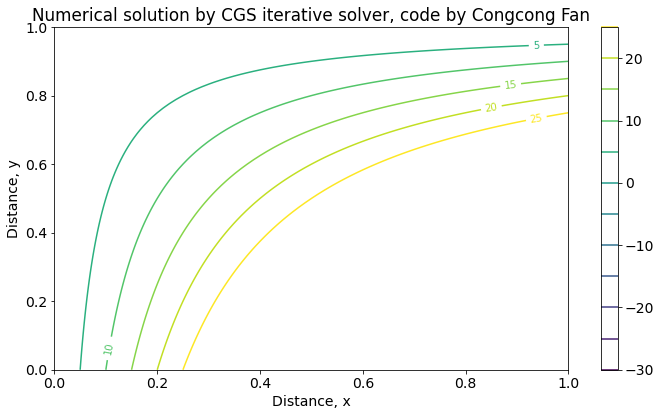

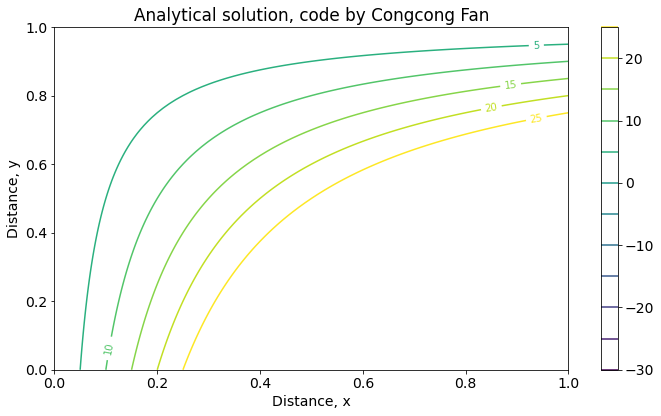

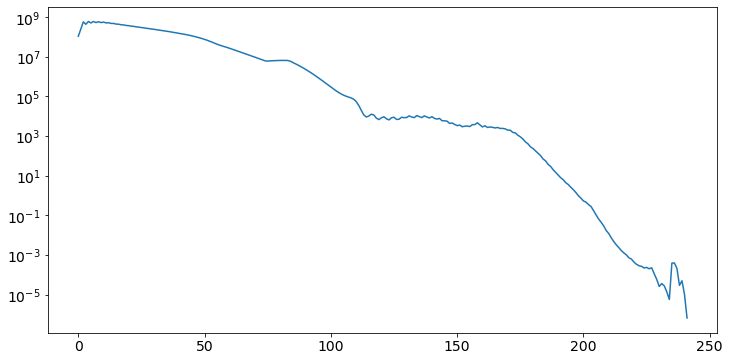

In [62]:
# Analytical solution
x = np.linspace(0,1,Nx)
y = np.linspace(0,1,Ny)
phi_A = np.zeros((Nx,Ny))
for i in range(Nx):
    for j in range(Ny):
        
        phi_A[i,j] = 500*np.exp(-50*((1-x[i])**2 + y[j]**2)) + 100*x[i]*(1-y[j])

plot_phi(phi_A, phi_A, Nx, Ny, 'CGS', convert=False)

plt.figure(figsize=(12,6))
plt.plot(Rlogger)
plt.yscale('log')


/Users/cong/opt/anaconda3/lib/python3.8/site-packages/mpl_toolkits/mplot3d/axes3d.py:1767: RuntimeWarning: divide by zero encountered in divide
  shade = ((normals / np.linalg.norm(normals, axis=1, keepdims=True))


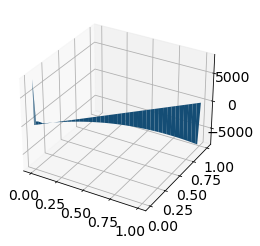

In [53]:
fig=plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(dx_list,dy_list,phi2D)
